In [7]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from torchvision.datasets import MNIST
from sklearn.model_selection import train_test_split
from explainers_lib.explainers.native.growing_spheres import GrowingSpheresExplainer
from explainers_lib.model import Model as ExplainerModel
from explainers_lib.datasets import Dataset


In [8]:
transform = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

train_ds = MNIST(root='./data', train=True, download=True, transform=transform)
test_ds = MNIST(root='./data', train=False, download=True, transform=transform)

train_ds, val_ds = train_test_split(train_ds, test_size=0.1, shuffle=True, random_state=42)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)


In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        flatten_dim = 64 * 8 * 8

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [10]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

class TransConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_c, out_c, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2)
        )
    def forward(self, x):
        return self.block(x)

class Encoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(1, 64),   # 32 -> 16
            ConvBlock(64, 128),  # 16 -> 8
            ConvBlock(128, 256), # 8 -> 4
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, latent_dim),
            nn.Tanh()
        )

    def forward(self, x):
        return self.encoder(x)
    
class Decoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 256 * 4 * 4),
            nn.Tanh()
        )

        self.decoder = nn.Sequential(
            TransConvBlock(256, 128),   # 4 -> 8
            TransConvBlock(128, 64),    # 8 -> 16
            TransConvBlock(64, 32),     # 16 -> 32
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 256, 4, 4)
        x = self.decoder(x)
        return x
    
class Autoencoder(nn.Module):
    def __init__(self, latent_dim=32):
        super().__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        return self.decoder(self.encoder(x))


In [11]:
class BatchedLatentWrapper(ExplainerModel):
    def __init__(self, decoder, cnn, device):
        self.decoder = decoder
        self.cnn = cnn
        self.device = device

    def predict(self, data: Dataset) -> np.ndarray:
        if isinstance(data, Dataset):
            d = data.data
        else:
            d = data
        latent_tensors = torch.tensor(d, dtype=torch.float32).to(self.device)
        
        with torch.no_grad():
            decoded_images = self.decoder(latent_tensors)
            predictions = self.cnn(decoded_images)
            predicted_classes = torch.argmax(predictions, dim=1)
                
        return predicted_classes.cpu().numpy()


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
cnn_model_path = 'models/torch_cnn_mnist_paper.pth'
if not os.path.exists('models'):
    os.makedirs('models')

cnn = CNN().to(device)

if os.path.exists(cnn_model_path):
    cnn.load_state_dict(torch.load(cnn_model_path, map_location=device))
else:
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=0.001)
    num_epochs = 10
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        cnn.train()
        running_loss = 0.0
        for imgs, labels in train_dl:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = cnn(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)

        avg_loss = running_loss / len(train_dl.dataset)

        cnn.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in val_dl:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = cnn(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        avg_val_loss = val_loss / len(val_dl.dataset)
        accuracy = correct / total

        print(f'Epoch {epoch+1}, CNN Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(cnn.state_dict(), cnn_model_path)
            print(f'Model saved to {cnn_model_path}')


Epoch 1, CNN Loss: 0.1843, Val Loss: 0.0457, Accuracy: 0.9858
Model saved to models/torch_cnn_mnist_paper.pth
Epoch 2, CNN Loss: 0.0706, Val Loss: 0.0399, Accuracy: 0.9880
Model saved to models/torch_cnn_mnist_paper.pth
Epoch 3, CNN Loss: 0.0521, Val Loss: 0.0358, Accuracy: 0.9895
Model saved to models/torch_cnn_mnist_paper.pth
Epoch 4, CNN Loss: 0.0418, Val Loss: 0.0384, Accuracy: 0.9897
Epoch 5, CNN Loss: 0.0352, Val Loss: 0.0394, Accuracy: 0.9897
Epoch 6, CNN Loss: 0.0300, Val Loss: 0.0338, Accuracy: 0.9903
Model saved to models/torch_cnn_mnist_paper.pth
Epoch 7, CNN Loss: 0.0259, Val Loss: 0.0344, Accuracy: 0.9910
Epoch 8, CNN Loss: 0.0229, Val Loss: 0.0415, Accuracy: 0.9902
Epoch 9, CNN Loss: 0.0204, Val Loss: 0.0430, Accuracy: 0.9892
Epoch 10, CNN Loss: 0.0192, Val Loss: 0.0397, Accuracy: 0.9918


In [14]:
from pytorch_msssim import ssim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

def SSIMLoss(x, y):
    return 1 - ssim(x, y, data_range=2.0)


class SobelLoss(nn.Module):
    def __init__(self):
        super().__init__()

        sobel_x = torch.tensor([
            [-1., 0., 1.],
            [-2., 0., 2.],
            [-1., 0., 1.]
        ]).repeat(1, 1, 1, 1)  # -> shape (1,1,3,3)

        sobel_y = torch.tensor([
            [-1., -2., -1.],
            [ 0.,  0.,  0.],
            [ 1.,  2.,  1.]
        ]).repeat(1, 1, 1, 1)

        self.sobel_x = nn.Parameter(sobel_x, requires_grad=False)
        self.sobel_y = nn.Parameter(sobel_y, requires_grad=False)

    def forward(self, img, target):
        # img, target: [B,1,H,W]
        gx_img = F.conv2d(img, self.sobel_x, padding=1, groups=1)
        gy_img = F.conv2d(img, self.sobel_y, padding=1, groups=1)

        gx_target = F.conv2d(target, self.sobel_x, padding=1, groups=1)
        gy_target = F.conv2d(target, self.sobel_y, padding=1, groups=1)

        return F.l1_loss(gx_img, gx_target) + F.l1_loss(gy_img, gy_target)


class VGGPerceptualLoss(nn.Module):
  def __init__(self):
      super().__init__()
      vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
      self.vgg_features = nn.Sequential(*list(vgg.features.children())[:16]).eval()
      for param in self.vgg_features.parameters():
          param.requires_grad = False

      self.register_buffer("mean", torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
      self.register_buffer("std",  torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

  def forward(self, input_img, target_img):
      # convert 1-channel to 3-channel
      if input_img.shape[1] == 1:
          input_img = input_img.repeat(1, 3, 1, 1)
          target_img = target_img.repeat(1, 3, 1, 1)

      # [-1,1] → [0,1]
      input_img  = (input_img  + 1) / 2
      target_img = (target_img + 1) / 2

      # normalize for VGG
      input_img  = (input_img  - self.mean) / self.std
      target_img = (target_img - self.mean) / self.std

      return nn.functional.mse_loss(
          self.vgg_features(input_img),
          self.vgg_features(target_img)
      )


In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import transforms as T
from tqdm import tqdm
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ae_model_path = 'models/torch_ae_mnist_paper.pth'

autoencoder = Autoencoder(latent_dim=32).to(device)

if os.path.exists(ae_model_path):
    autoencoder.load_state_dict(torch.load(ae_model_path, map_location=device))
else:
    criterion_mse = nn.MSELoss()
    criterion_vgg = VGGPerceptualLoss().to(device)
    sobel_loss = SobelLoss().to(device)
    optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5, 
        patience=3, 
        min_lr=1e-6
    )

    num_epochs = 500
    patience = 8
    min_delta = 1e-4
    best_val_loss = float("inf")
    early_stop_counter = 0

    for epoch in range(num_epochs):
        autoencoder.train()
        pbar = tqdm(train_dl, desc=f"Epoch {epoch+1}/{num_epochs}")
        epoch_loss = 0

        for images, _ in pbar:
            images = images.to(device)

            recon = autoencoder(images)
            loss_mse = criterion_mse(recon, images)
            loss_ssim = SSIMLoss(recon, images)
            loss_vgg = criterion_vgg(recon, images)
            loss_grad = sobel_loss(recon, images)

            loss = (
                0.5 * loss_mse +
                0.3 * loss_ssim +
                0.1 * loss_vgg +
                0.1 * loss_grad
            )

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            pbar.set_postfix({"loss": loss.item()})

        autoencoder.eval()
        val_loss = 0
        with torch.no_grad():
            for images, _ in val_dl:
                images = images.to(device)
                recon = autoencoder(images)
                loss_mse = criterion_mse(recon, images)
                loss_ssim = SSIMLoss(recon, images)
                loss_vgg = criterion_vgg(recon, images)
                loss_grad = sobel_loss(recon, images)

                loss = (
                    0.5 * loss_mse +
                    0.3 * loss_ssim +
                    0.1 * loss_vgg +
                    0.1 * loss_grad
                )
                val_loss += loss.item()

        val_loss /= len(val_dl)
        print(f"Validation loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        if val_loss + min_delta < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
            torch.save(autoencoder.state_dict(), ae_model_path)
            print("⬇️ New best model saved.")
        else:
            early_stop_counter += 1
            print(f"⚠️ Plateau detected ({early_stop_counter}/{patience})")

        if early_stop_counter >= patience:
            print("⛔ Early stopping triggered due to plateau.")
            break
    print(f'Model saved to {ae_model_path}')


Epoch 1/500: 100%|██████████| 1688/1688 [00:09<00:00, 182.04it/s, loss=2.03]


Validation loss: 2.0440
⬇️ New best model saved.


Epoch 2/500: 100%|██████████| 1688/1688 [00:09<00:00, 183.60it/s, loss=1.13]


Validation loss: 1.3562
⬇️ New best model saved.


Epoch 3/500: 100%|██████████| 1688/1688 [00:09<00:00, 183.67it/s, loss=1.09] 


Validation loss: 1.0149
⬇️ New best model saved.


Epoch 4/500: 100%|██████████| 1688/1688 [00:09<00:00, 182.86it/s, loss=0.763]


Validation loss: 0.7412
⬇️ New best model saved.


Epoch 5/500: 100%|██████████| 1688/1688 [00:09<00:00, 183.76it/s, loss=0.497]


Validation loss: 0.4648
⬇️ New best model saved.


Epoch 6/500: 100%|██████████| 1688/1688 [00:09<00:00, 184.77it/s, loss=0.386]


Validation loss: 0.4409
⬇️ New best model saved.


Epoch 7/500: 100%|██████████| 1688/1688 [00:09<00:00, 183.96it/s, loss=0.433]


Validation loss: 0.4072
⬇️ New best model saved.


Epoch 8/500: 100%|██████████| 1688/1688 [00:09<00:00, 183.72it/s, loss=0.39] 


Validation loss: 0.3885
⬇️ New best model saved.


Epoch 9/500: 100%|██████████| 1688/1688 [00:09<00:00, 180.77it/s, loss=0.368]


Validation loss: 0.3858
⬇️ New best model saved.


Epoch 10/500: 100%|██████████| 1688/1688 [00:09<00:00, 183.96it/s, loss=0.315]


Validation loss: 0.3700
⬇️ New best model saved.


Epoch 11/500: 100%|██████████| 1688/1688 [00:09<00:00, 181.10it/s, loss=0.37] 


Validation loss: 0.3581
⬇️ New best model saved.


Epoch 12/500: 100%|██████████| 1688/1688 [00:09<00:00, 185.98it/s, loss=0.329]


Validation loss: 0.3539
⬇️ New best model saved.


Epoch 13/500: 100%|██████████| 1688/1688 [00:08<00:00, 191.70it/s, loss=0.299]


Validation loss: 0.3427
⬇️ New best model saved.


Epoch 14/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.17it/s, loss=0.254]


Validation loss: 0.3377
⬇️ New best model saved.


Epoch 15/500: 100%|██████████| 1688/1688 [00:08<00:00, 189.53it/s, loss=0.368]


Validation loss: 0.3377
⚠️ Plateau detected (1/8)


Epoch 16/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.55it/s, loss=0.348]


Validation loss: 0.3274
⬇️ New best model saved.


Epoch 17/500: 100%|██████████| 1688/1688 [00:08<00:00, 191.90it/s, loss=0.341]


Validation loss: 0.3241
⬇️ New best model saved.


Epoch 18/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.33it/s, loss=0.254]


Validation loss: 0.3199
⬇️ New best model saved.


Epoch 19/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.91it/s, loss=0.303]


Validation loss: 0.3191
⬇️ New best model saved.


Epoch 20/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.08it/s, loss=0.27] 


Validation loss: 0.3115
⬇️ New best model saved.


Epoch 21/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.40it/s, loss=0.371]


Validation loss: 0.3097
⬇️ New best model saved.


Epoch 22/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.34it/s, loss=0.274]


Validation loss: 0.3045
⬇️ New best model saved.


Epoch 23/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.41it/s, loss=0.239]


Validation loss: 0.3054
⚠️ Plateau detected (1/8)


Epoch 24/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.63it/s, loss=0.331]


Validation loss: 0.2990
⬇️ New best model saved.


Epoch 25/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.56it/s, loss=0.231]


Validation loss: 0.2974
⬇️ New best model saved.


Epoch 26/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.52it/s, loss=0.222]


Validation loss: 0.2950
⬇️ New best model saved.


Epoch 27/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.41it/s, loss=0.268]


Validation loss: 0.2908
⬇️ New best model saved.


Epoch 28/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.32it/s, loss=0.242]


Validation loss: 0.2905
⬇️ New best model saved.


Epoch 29/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.50it/s, loss=0.249]


Validation loss: 0.2954
⚠️ Plateau detected (1/8)


Epoch 30/500: 100%|██████████| 1688/1688 [00:08<00:00, 191.93it/s, loss=0.218]


Validation loss: 0.2875
⬇️ New best model saved.


Epoch 31/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.92it/s, loss=0.259]


Validation loss: 0.2895
⚠️ Plateau detected (1/8)


Epoch 32/500: 100%|██████████| 1688/1688 [00:08<00:00, 191.47it/s, loss=0.264]


Validation loss: 0.2825
⬇️ New best model saved.


Epoch 33/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.84it/s, loss=0.242]


Validation loss: 0.2861
⚠️ Plateau detected (1/8)


Epoch 34/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.91it/s, loss=0.276]


Validation loss: 0.2831
⚠️ Plateau detected (2/8)


Epoch 35/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.37it/s, loss=0.29] 


Validation loss: 0.2827
⚠️ Plateau detected (3/8)


Epoch 36/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.65it/s, loss=0.218]


Validation loss: 0.2783
⬇️ New best model saved.


Epoch 37/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.10it/s, loss=0.289]


Validation loss: 0.2774
⬇️ New best model saved.


Epoch 38/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.58it/s, loss=0.257]


Validation loss: 0.2768
⬇️ New best model saved.


Epoch 39/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.52it/s, loss=0.221]


Validation loss: 0.2786
⚠️ Plateau detected (1/8)


Epoch 40/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.11it/s, loss=0.2]  


Validation loss: 0.2759
⬇️ New best model saved.


Epoch 41/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.19it/s, loss=0.265]


Validation loss: 0.2701
⬇️ New best model saved.


Epoch 42/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.73it/s, loss=0.191]


Validation loss: 0.2734
⚠️ Plateau detected (1/8)


Epoch 43/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.28it/s, loss=0.257]


Validation loss: 0.2729
⚠️ Plateau detected (2/8)


Epoch 44/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.11it/s, loss=0.224]


Validation loss: 0.2700
⬇️ New best model saved.


Epoch 45/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.23it/s, loss=0.234]


Validation loss: 0.2714
⚠️ Plateau detected (1/8)


Epoch 46/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.07it/s, loss=0.246]


Validation loss: 0.2655
⬇️ New best model saved.


Epoch 47/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.00it/s, loss=0.216]


Validation loss: 0.2682
⚠️ Plateau detected (1/8)


Epoch 48/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.50it/s, loss=0.202]


Validation loss: 0.2668
⚠️ Plateau detected (2/8)


Epoch 49/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.12it/s, loss=0.213]


Validation loss: 0.2653
⬇️ New best model saved.


Epoch 50/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.04it/s, loss=0.196]


Validation loss: 0.2620
⬇️ New best model saved.


Epoch 51/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.23it/s, loss=0.248]


Validation loss: 0.2639
⚠️ Plateau detected (1/8)


Epoch 52/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.73it/s, loss=0.234]


Validation loss: 0.2611
⬇️ New best model saved.


Epoch 53/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.98it/s, loss=0.192]


Validation loss: 0.2600
⬇️ New best model saved.


Epoch 54/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.84it/s, loss=0.189]


Validation loss: 0.2625
⚠️ Plateau detected (1/8)


Epoch 55/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.82it/s, loss=0.23] 


Validation loss: 0.2621
⚠️ Plateau detected (2/8)


Epoch 56/500: 100%|██████████| 1688/1688 [00:08<00:00, 190.67it/s, loss=0.195]


Validation loss: 0.2609
⚠️ Plateau detected (3/8)


Epoch 57/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.51it/s, loss=0.267]


Validation loss: 0.2574
⬇️ New best model saved.


Epoch 58/500: 100%|██████████| 1688/1688 [00:08<00:00, 189.19it/s, loss=0.223]


Validation loss: 0.2591
⚠️ Plateau detected (1/8)


Epoch 59/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.35it/s, loss=0.238]


Validation loss: 0.2587
⚠️ Plateau detected (2/8)


Epoch 60/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.21it/s, loss=0.165]


Validation loss: 0.2575
⚠️ Plateau detected (3/8)


Epoch 61/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.99it/s, loss=0.201]


Validation loss: 0.2553
⬇️ New best model saved.


Epoch 62/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.57it/s, loss=0.195]


Validation loss: 0.2559
⚠️ Plateau detected (1/8)


Epoch 63/500: 100%|██████████| 1688/1688 [00:08<00:00, 189.27it/s, loss=0.172]


Validation loss: 0.2559
⚠️ Plateau detected (2/8)


Epoch 64/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.84it/s, loss=0.195]


Validation loss: 0.2546
⬇️ New best model saved.


Epoch 65/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.14it/s, loss=0.189]


Validation loss: 0.2522
⬇️ New best model saved.


Epoch 66/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.45it/s, loss=0.202]


Validation loss: 0.2554
⚠️ Plateau detected (1/8)


Epoch 67/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.32it/s, loss=0.193]


Validation loss: 0.2539
⚠️ Plateau detected (2/8)


Epoch 68/500: 100%|██████████| 1688/1688 [00:08<00:00, 195.04it/s, loss=0.201]


Validation loss: 0.2537
⚠️ Plateau detected (3/8)


Epoch 69/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.65it/s, loss=0.219]


Validation loss: 0.2553
⚠️ Plateau detected (4/8)


Epoch 70/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.40it/s, loss=0.172]


Validation loss: 0.2425
⬇️ New best model saved.


Epoch 71/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.80it/s, loss=0.198]


Validation loss: 0.2425
⚠️ Plateau detected (1/8)


Epoch 72/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.37it/s, loss=0.186]


Validation loss: 0.2425
⚠️ Plateau detected (2/8)


Epoch 73/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.41it/s, loss=0.252]


Validation loss: 0.2424
⚠️ Plateau detected (3/8)


Epoch 74/500: 100%|██████████| 1688/1688 [00:08<00:00, 192.80it/s, loss=0.141]


Validation loss: 0.2433
⚠️ Plateau detected (4/8)


Epoch 75/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.99it/s, loss=0.216]


Validation loss: 0.2421
⬇️ New best model saved.


Epoch 76/500: 100%|██████████| 1688/1688 [00:08<00:00, 195.04it/s, loss=0.175]


Validation loss: 0.2412
⬇️ New best model saved.


Epoch 77/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.42it/s, loss=0.176]


Validation loss: 0.2416
⚠️ Plateau detected (1/8)


Epoch 78/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.78it/s, loss=0.23] 


Validation loss: 0.2415
⚠️ Plateau detected (2/8)


Epoch 79/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.55it/s, loss=0.206]


Validation loss: 0.2414
⚠️ Plateau detected (3/8)


Epoch 80/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.44it/s, loss=0.13] 


Validation loss: 0.2408
⬇️ New best model saved.


Epoch 81/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.32it/s, loss=0.18] 


Validation loss: 0.2427
⚠️ Plateau detected (1/8)


Epoch 82/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.69it/s, loss=0.173]


Validation loss: 0.2405
⬇️ New best model saved.


Epoch 83/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.69it/s, loss=0.18] 


Validation loss: 0.2415
⚠️ Plateau detected (1/8)


Epoch 84/500: 100%|██████████| 1688/1688 [00:08<00:00, 195.09it/s, loss=0.183]


Validation loss: 0.2422
⚠️ Plateau detected (2/8)


Epoch 85/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.68it/s, loss=0.223]


Validation loss: 0.2412
⚠️ Plateau detected (3/8)


Epoch 86/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.54it/s, loss=0.179]


Validation loss: 0.2406
⚠️ Plateau detected (4/8)


Epoch 87/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.83it/s, loss=0.161]


Validation loss: 0.2370
⬇️ New best model saved.


Epoch 88/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.56it/s, loss=0.229]


Validation loss: 0.2374
⚠️ Plateau detected (1/8)


Epoch 89/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.44it/s, loss=0.149]


Validation loss: 0.2375
⚠️ Plateau detected (2/8)


Epoch 90/500: 100%|██████████| 1688/1688 [00:08<00:00, 195.28it/s, loss=0.134]


Validation loss: 0.2373
⚠️ Plateau detected (3/8)


Epoch 91/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.45it/s, loss=0.185]


Validation loss: 0.2372
⚠️ Plateau detected (4/8)


Epoch 92/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.01it/s, loss=0.144]


Validation loss: 0.2354
⬇️ New best model saved.


Epoch 93/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.50it/s, loss=0.143]


Validation loss: 0.2353
⬇️ New best model saved.


Epoch 94/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.57it/s, loss=0.128]


Validation loss: 0.2355
⚠️ Plateau detected (1/8)


Epoch 95/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.74it/s, loss=0.169]


Validation loss: 0.2356
⚠️ Plateau detected (2/8)


Epoch 96/500: 100%|██████████| 1688/1688 [00:08<00:00, 195.13it/s, loss=0.172]


Validation loss: 0.2353
⚠️ Plateau detected (3/8)


Epoch 97/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.45it/s, loss=0.157]


Validation loss: 0.2355
⚠️ Plateau detected (4/8)


Epoch 98/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.37it/s, loss=0.145]


Validation loss: 0.2347
⬇️ New best model saved.


Epoch 99/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.21it/s, loss=0.143]


Validation loss: 0.2347
⚠️ Plateau detected (1/8)


Epoch 100/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.72it/s, loss=0.169]


Validation loss: 0.2348
⚠️ Plateau detected (2/8)


Epoch 101/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.12it/s, loss=0.171]


Validation loss: 0.2345
⬇️ New best model saved.


Epoch 102/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.50it/s, loss=0.159]


Validation loss: 0.2347
⚠️ Plateau detected (1/8)


Epoch 103/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.76it/s, loss=0.134]


Validation loss: 0.2347
⚠️ Plateau detected (2/8)


Epoch 104/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.79it/s, loss=0.118]


Validation loss: 0.2348
⚠️ Plateau detected (3/8)


Epoch 105/500: 100%|██████████| 1688/1688 [00:08<00:00, 193.46it/s, loss=0.144]


Validation loss: 0.2350
⚠️ Plateau detected (4/8)


Epoch 106/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.82it/s, loss=0.171]


Validation loss: 0.2343
⬇️ New best model saved.


Epoch 107/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.72it/s, loss=0.132]


Validation loss: 0.2345
⚠️ Plateau detected (1/8)


Epoch 108/500: 100%|██████████| 1688/1688 [00:08<00:00, 195.19it/s, loss=0.153]


Validation loss: 0.2344
⚠️ Plateau detected (2/8)


Epoch 109/500: 100%|██████████| 1688/1688 [00:08<00:00, 195.14it/s, loss=0.155]


Validation loss: 0.2345
⚠️ Plateau detected (3/8)


Epoch 110/500: 100%|██████████| 1688/1688 [00:08<00:00, 195.60it/s, loss=0.189]


Validation loss: 0.2347
⚠️ Plateau detected (4/8)


Epoch 111/500: 100%|██████████| 1688/1688 [00:08<00:00, 195.04it/s, loss=0.191]


Validation loss: 0.2342
⬇️ New best model saved.


Epoch 112/500: 100%|██████████| 1688/1688 [00:08<00:00, 195.28it/s, loss=0.149]


Validation loss: 0.2342
⚠️ Plateau detected (1/8)


Epoch 113/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.50it/s, loss=0.175]


Validation loss: 0.2342
⚠️ Plateau detected (2/8)


Epoch 114/500: 100%|██████████| 1688/1688 [00:08<00:00, 196.40it/s, loss=0.147]


Validation loss: 0.2344
⚠️ Plateau detected (3/8)


Epoch 115/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.40it/s, loss=0.154]


Validation loss: 0.2342
⚠️ Plateau detected (4/8)


Epoch 116/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.45it/s, loss=0.168]


Validation loss: 0.2343
⚠️ Plateau detected (5/8)


Epoch 117/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.18it/s, loss=0.161]


Validation loss: 0.2344
⚠️ Plateau detected (6/8)


Epoch 118/500: 100%|██████████| 1688/1688 [00:08<00:00, 194.90it/s, loss=0.144]


Validation loss: 0.2343
⚠️ Plateau detected (7/8)


Epoch 119/500: 100%|██████████| 1688/1688 [00:08<00:00, 195.12it/s, loss=0.197]


Validation loss: 0.2343
⚠️ Plateau detected (8/8)
⛔ Early stopping triggered due to plateau.
Model saved to models/torch_ae_mnist_paper.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9995127].


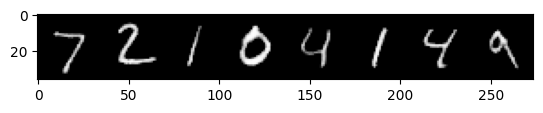

In [ ]:
# show how the ae works 

import torchvision


for images, _ in test_dl:
    images = images.to(device)
    with torch.no_grad():
        recon = autoencoder(images)
    plt.imshow(torchvision.utils.make_grid(recon[:8].cpu(), nrow=8).permute(1, 2, 0).squeeze(), cmap='gray')
    plt.show()
    break


In [45]:
from sklearn.preprocessing import FunctionTransformer

device = "cuda" if torch.cuda.is_available() else "cpu"

autoencoder = Autoencoder(latent_dim=32).to(device)
autoencoder.load_state_dict(torch.load('models/torch_ae_mnist_paper.pth', map_location=device))

cnn = CNN().to(device)
cnn.load_state_dict(torch.load('models/torch_cnn_mnist_paper.pth', map_location=device))

n_samples = 10

batch = next(iter(test_dl))
images_batch, labels_batch = batch
imgs = images_batch[:n_samples].to(device)
targets = labels_batch[:n_samples].cpu().tolist()

with torch.no_grad():
    latent_tensors = autoencoder.encoder(imgs)

latent_instance_np = latent_tensors.cpu().detach().numpy()
latent_dim_actual = latent_instance_np.shape[1]
feature_names = [f'l{i}' for i in range(latent_dim_actual)]

data_df = pd.DataFrame(latent_instance_np, columns=feature_names)

from sklearn.compose import ColumnTransformer


identity = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', feature_names),
        # ("cat", OneHotEncoder(), []),

    ],    remainder='drop'
)

identity.fit(data_df)

latent_dataset = Dataset(
    df=data_df,
    target=targets,
    features=feature_names,
    categorical_features=[],
    continuous_features=feature_names,
    immutable_features=[],
    allowable_ranges={},
    preprocessor=identity
)

print(f"Created latent_dataset with {len(data_df)} samples and {latent_dim_actual} latent dims")

class LatentToClassPipeline(nn.Module):
    def __init__(self, decoder, cnn):
        super().__init__()
        self.decoder = decoder
        self.cnn = cnn

    def forward(self, x):
        # 1. Decode
        decoded = self.decoder(x)
        # 2. Scale (Your custom logic)
        decoded = decoded * 0.5 
        # 3. Classify
        logits = self.cnn(decoded)
        return logits

from explainers_lib.model import TorchModel

latent_model =  TorchModel(LatentToClassPipeline(autoencoder.decoder, cnn))
explainer = GrowingSpheresExplainer()

sample_index = 0
test_instance = latent_dataset
explanation = explainer.explain(latent_model, test_instance)
cfs = explanation



Created latent_dataset with 10 samples and 32 latent dims


10instance [00:36,  3.61s/instance]


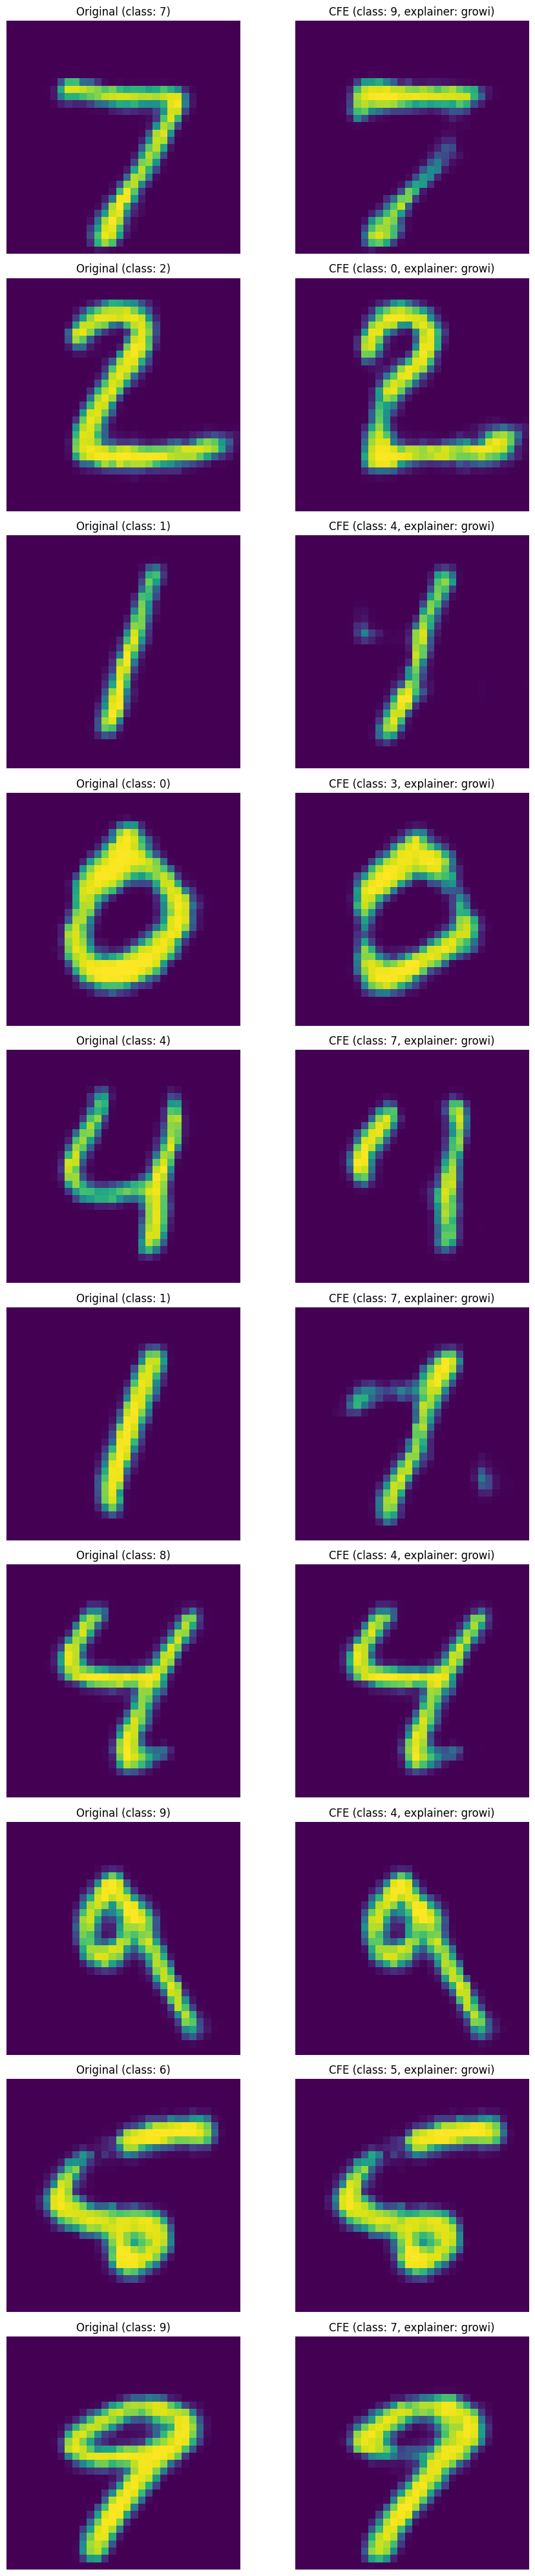

In [46]:
n = len(cfs)
plt.figure(figsize=(10, 4 * n))
autoencoder.to(device)
autoencoder.eval()

for i in range(n):
    cf = cfs[i]

    # ---- ORIGINAL RECONSTRUCTION ----
    org_latent = torch.tensor(cf.original_data, dtype=torch.float32, device=device).unsqueeze(0)
    org_recon = autoencoder.decoder(org_latent)      # shape [1, 3, 128, 128]

    org_recon_np = org_recon.detach().cpu().permute(0, 2, 3, 1).numpy()[0]

    # map from [-1, 1] → [0, 1]
    org_recon_np = (org_recon_np + 1) / 2
    org_recon_np = org_recon_np.clip(0, 1)

    # ---- COUNTERFACTUAL RECONSTRUCTION ----
    cf_latent = torch.tensor(cf.data, dtype=torch.float32, device=device).unsqueeze(0)
    cfe_recon = autoencoder.decoder(cf_latent)

    cfe_recon_np = cfe_recon.detach().cpu().permute(0, 2, 3, 1).numpy()[0]
    cfe_recon_np = (cfe_recon_np + 1) / 2
    cfe_recon_np = cfe_recon_np.clip(0, 1)

    # ---- PLOTTING ----
    plt.subplot(n, 2, 2 * i + 1)
    plt.imshow(org_recon_np)
    plt.title(f"Original (class: {cf.original_class})")
    plt.axis("off")

    plt.subplot(n, 2, 2 * i + 2)
    plt.imshow(cfe_recon_np)
    plt.title(f"CFE (class: {cf.target_class}, explainer: {cf.explainer[:5]})")
    plt.axis("off")

plt.tight_layout()
plt.show()
